In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *

import time

In [ ]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU',)
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


The powerlaw hamiltonian is defined as follow: 

$$
H=\sum_{j=1}^{n} \sum_{k=j+1}^n \frac{1}{(j-k)^\alpha} (J^x X_j X_{k} + J^y Y_j Y_{k} + J^z Z_j Z_{k}) + \sum_{j=1}^{n} h_j^x X_j + h_j^y Y_j + h_j^z Z_j,
$$

In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 10

# QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)
powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

# H = QIMF.ham_xyz
H = powerlaw.ham_xyz
print(H)

init = Statevector.from_label("10"*int(n/2))
t = 10
r = 100
m = 1
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

In [ ]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  circ_pf1 = QuantumCircuit(n)
  circ_pf1.set_statevector(ideal_psi.data)
  circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1.save_statevector(label=f"sv_{s}")

  circ_pf1 = circ_pf1.decompose(reps=2)
  res = simulator_gpu.run(circ_pf1).result()
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  for ss in range (1, m+1):
    print("step:", ss)
    circ_pf2 = QuantumCircuit(n)
    circ_pf2.set_statevector(ideal_psi.data)

    circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=2)

    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(circ_pf2).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)

  print(np.linalg.norm(ideal_psi - psi))

  print("pf1 step:", s)

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

In [ ]:
n, t = 10, 5*2
r = 100
H_typical = 'typical'
psi0 = '1010'
grouping = 'xyz'  # parity, xyz
pf_order = 1  # product formula order: 1, 2, 4

if psi0 == '0000':
    init_state = Statevector.from_label('0'*n)
elif psi0 == '1010':
    init_state = Statevector.from_label('10'* (n//2)+'1'*(n%2))
# elif psi0 == 'rand':
else:
    raise ValueError('invalid initial state')

if H_typical=='typical':
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8001, hy=0.8908, Jx=1, pbc=False)
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045,Jx=1, pbc=False)
    powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

elif H_typical=='atypical':
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8, hy=0.9, Jx=1, pbc=False)
    # QIMF = Nearest_Neighbour_1d(n, hx=0.0, hy=0.9045, Jx=1, pbc=False)
    powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

else:
    raise ValueError('invalid typical')

if grouping == 'parity':
    H_list = powerlaw.ham_par
    # H_list = [h for h in QIMF.ham_par]
elif grouping == 'xyz':
    H_list = powerlaw.ham_xyz
else:
    raise ValueError('invalid grouping')
print('Hamiltonian list: \n', H_list)

if pf_order <= 2:
    appro_U, exact_U = pf(H_list, t/r, 1, order=pf_order, return_exact=True, use_jax=False)
else:
    appro_U = pf_high(H_list, t/r, 1, order=pf_order)
    exact_U = expH(sum(H_list), t/r)

emp_err_list, entropy_list, purity_list = [], [], []

current_state = init_state.data

for d in range(r):
    print('+', end='')
    # U_exact = expH(QIMF.ham, t)
    current_state = current_state/np.linalg.norm(current_state)
    ideal_state = exact_U @ current_state
    current_state = appro_U @ current_state
    #finl_state = U_exact @ init_state
    rdm1 = partial_trace(DensityMatrix(Statevector(current_state)), [0])
    rdm2 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1])
    rdm3 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1,2])
    rdm4 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1,2,4])
    ## qiskit partial trace is not a valid density matrix within the tolerance for entropy
    # purity_list.append(rdm.purity())
    # print(rdm1)
    if rdm1.is_valid() and rdm2.is_valid() and rdm3.is_valid() and rdm4.is_valid():
        pass
    else:
        print('not valid density matrix')
        print(d, rdm1.is_valid(), np.trace(rdm1), rdm1.atol, rdm1.rtol)
        print(rdm1.is_valid(), rdm2.is_valid(), rdm3.is_valid(), rdm4.is_valid())
        rdm1, rdm2, rdm3, rdm4 = DensityMatrix(rdm1.data/np.trace(rdm1)), DensityMatrix(rdm2.data/np.trace(rdm2)), DensityMatrix(rdm3.data/np.trace(rdm3)), DensityMatrix(rdm3.data/np.trace(rdm4))
    # print(isinstance(rdm1, (Statevector, DensityMatrix)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(temp_entropy)
    entropy_list.append(temp_entropy)
    emp_err_list.append(np.linalg.norm(current_state - ideal_state))

if pf_order <= 2:
    worst_bound = tight_bound(H_list, pf_order, t/r, 1)
    averg_bound = tight_bound(H_list, pf_order, t/r, 1, type='fro')
t_list = np.array(range(r))*t/r
entropy_list = np.array(entropy_list)

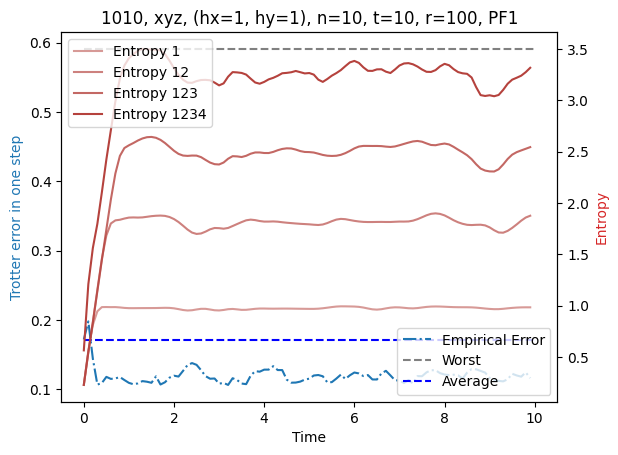

In [ ]:
fig, ax = plt.subplots()
ax.plot(t_list, emp_err_list, '-.', label=f'Empirical Error', c="tab:blue")
if pf_order <= 2:
    ax.hlines(worst_bound, 0, t, colors='grey', linestyles='dashed', label='Worst')
    ax.hlines(averg_bound, 0, t, colors='blue', linestyles='dashed', label='Average')

ax.set_xlabel('Time')
ax.set_ylabel('Trotter error in one step', color='tab:blue')
ax.set_title(f'{psi0}, {grouping}, (hx={powerlaw.hx}, hy={powerlaw.hy}), n={n}, t={t}, r={r}, PF{pf_order}')
# twin y axis for empirical error
ax2 = ax.twinx()
ax2.set_ylabel('Entropy', color='tab:red')
ax2.plot(t_list, entropy_list[:, 0], '-', label=f'Entropy 1', c="#b5423d88")
ax2.plot(t_list, entropy_list[:, 1], '-', label=f'Entropy 12', c="#b5423dAA")
ax2.plot(t_list, entropy_list[:, 2], '-', label=f'Entropy 123', c="#b5423dCC")
ax2.plot(t_list, entropy_list[:, 3], '-', label=f'Entropy 1234', c="#b5423dFF")
ax.legend(loc='lower right');
ax2.legend()

In [ ]:
circ_pf2.draw()

In [ ]:
entropy_list = []
entropy_list2 = []

for s in range(1, r+1):
    rdm1 = partial_trace((states[s-1]), list(range(1, n)))
    rdm2 = partial_trace((states[s-1]), list(range(2, n)))
    rdm3 = partial_trace((states[s-1]), list(range(3, n)))
    rdm4 = partial_trace((states[s-1]), list(range(4, n)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    rdm12 = partial_trace((better_states[s-1]), list(range(1, n)))
    rdm22 = partial_trace((better_states[s-1]), list(range(2, n)))
    rdm32 = partial_trace((better_states[s-1]), list(range(3, n)))
    rdm42 = partial_trace((better_states[s-1]), list(range(4, n)))
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

In [ ]:
trotter = []
for s in range(0, r):
  tro = np.linalg.norm(better_states[s] - states[s])
  # print(tro)
  trotter.append(tro)

error: vector, inner product 1- <||>^2 infidelity -> global phase
density matrix, trace distance

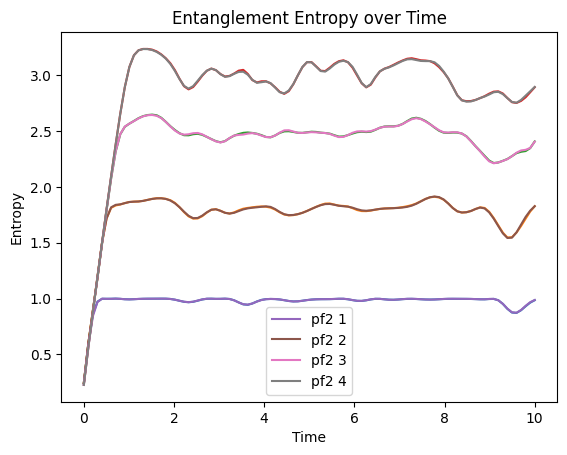

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

# Extract the first element of each sublist in entropy_list
entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]


# Extract the first element of each sublist in entropy_list2
entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

# Create the plot
plt.plot(times, entropy_values_1)
plt.plot(times, entropy_values_2)
plt.plot(times, entropy_values_3)
plt.plot(times, entropy_values_4)

plt.plot(times, entropy_values_12, label='pf2 1')
plt.plot(times, entropy_values_22, label='pf2 2')
plt.plot(times, entropy_values_32, label='pf2 3')
plt.plot(times, entropy_values_42, label='pf2 4')

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.legend()
plt.show()

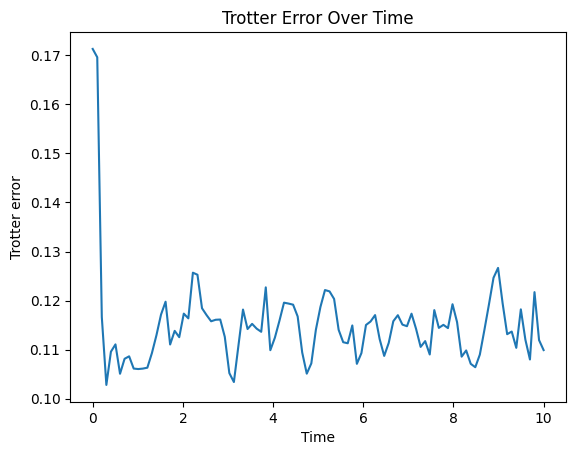

In [ ]:
plt.plot(times, trotter)
plt.xlabel("Time")
plt.ylabel("Trotter error")
plt.title("Trotter Error Over Time")
plt.show()